In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import datetime
import re
import os
import glob
import math
import gc
import shutil

from config import config
import YL_assistant

import networkx as nx

In [2]:
TRAIN_MODE = True

OPERATION = 'PRETRAIN'  # 'PRETRAIN'  'TRAIN_C'   'FINETUNE'   'TEST', 'BACKTEST'

MODEL_ID = 'YK.05'
HISTORY_LEN = 400
SEQ_YEAR_SPAN = 15
NOTE = 'MAP2'

DATA_THEME = str(HISTORY_LEN).zfill(3) + '-' + str(SEQ_YEAR_SPAN).zfill(2) + '-' + NOTE
COPY_IDS_DS_DATA_FROM = None  # "_DATA_400-15-Test"  None

NUMBER_QUERIES = 3
STARTING_PERCENT = 0
ENDING_PERCENT = 0
TRAIN_PERCENT= 97   #------ 96
VALID_PERCENT = 3   #------ 4
TEST_PERCENT = 100 - TRAIN_PERCENT - VALID_PERCENT
FILTER_FOR_GOOD_DATA = True

BATCH_SIZE = 25 # 25 for headers 6.

TEAM_EMBS = 50  #
DECODE_BASE_DATE = False
EMBED_AB_COLS = False    # True: Pls choose a small LR so that we have plenty of train epochs and the embedded values have enough chance to seek their proper places.
ODDS_IN_ENCODER = 'None'    # 'None', 'Focus', 'All'
ODDS_IN_DECODER = 'All'     # 'None', 'Focus', 'All'
ODDS_IN_LOSS = 'Focus'      # 'Focus', 'All'
ADDITIONAL_D_MODEL = 0   #------------ Try increase it when underfitting.

TRANSFORMER_LAYERS = 30        #----------30
TRANSFORMER_HEADS = 6
BALANCE_POS_CODE = True        # True: Weakens positional code compared to embedded values.
DROPOUT = 0.0  # 0.1
ADAPTORS_LAYERS = 0 #------------ 10
ADAPTORS_WIDTH_FACTOR = 30  # 30

# This is an exponential curve that hits STARTING_LEARNING_RATE at step zero and EXAMPLE_LEARNING_RATE at step EXAMPLE_LEARNING_STEP.
# lr(step) = STARTING_LEARNING_RATE * pow( pow(EXAMPLE_LEARNING_RATE/STARTING_LEARNING_RATE, 1/EXAMPLE_LEARNING_STEP), step )
STARTING_LEARNING_RATE = 5e-7
EXAMPLE_LEARNING_RATE = STARTING_LEARNING_RATE * 0.5    #------------ 0.5 worked.
EXAMPLE_LEARNING_STEP = 100

MODEL_ACTIVATION = 'softmax'    # 'softmax', 'sigmoid', 'relu', 'open'
LOSS_TYPE = 'profit'           # 'profit', 'entropy'
VECTOR_BETTING = False
STAKE_TECHNIQUE = 'independent'         # 'independent', 'majority', 'riskest'

MODEL_TYPE_CHECK = False
GET_VAL_LOSS_0 = False
IGNORE_HISTORY = False
SIMPLIFY_ADAPTOR = True

In [3]:
COUNTRY = 'England'
FOCUS_BOOKIE = 1    # Subject to the 3 ODDS_IN_... definitions.
NUMBER_BOOKIES = 5  # Take William Hills, Bet&Win, and Bet365. Other bookies' odds list change over years and leagues.
PREFERED_ORDER = ['B365', 'WH']   # Implies the order only.
BOOKIE_TO_EXCLUDE = []    # 'BWIN' odds don't show up since mid Febrary 2025. This may reduce the effective NUMBER_BOOKIES.
DIVIISONS = ['E0', 'E1', 'E2', 'E3']    # 'EC', the Conference league, is excluded as some odds makers are not archived for the league since 2013.
REPEATING_BOOKIE = None    #-----------------------------------

In [4]:
ODDS_COLS = []
for b in range(NUMBER_BOOKIES):
    ODDS_COLS += ['HDA'+str(b)+'H', 'HDA'+str(b)+'D', 'HDA'+str(b)+'A']

In [5]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ODDS_COLS
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols
Required_Non_Odds_cols = Div_cols + Date_cols + Team_cols + Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols

# underscore_prefixed lists have discontinued columns.
BBAB_cols = BB_cols + AB_cols

# Make sure Odds_cols comes first !!!
_Cols_to_Always_Normalize = Odds_cols

_Label_cols = Full_Goal_cols + Odds_cols

bbab_odds_start = BBAB_cols.index(Odds_cols[0])
bb_odds_start = BB_cols.index(Odds_cols[0])
label_odds_start = _Label_cols.index(Odds_cols[0])

In [6]:
history_folder = os.path.join('.', 'history')
country_folder = os.path.join('.', "data", "football-data-co-uk", COUNTRY)
gameHistory_folder_path = os.path.join(country_folder, 'Game_History')
if not os.path.exists(gameHistory_folder_path): os.makedirs(gameHistory_folder_path, exist_ok=False)
countryTheme_folder_path = os.path.join(country_folder, '_DATA_' + DATA_THEME)
if not os.path.exists(countryTheme_folder_path): os.makedirs(countryTheme_folder_path, exist_ok=False)
map_folder_path = os.path.join(countryTheme_folder_path, '_id_map')     # do not change to '_map' for backward compatibility
if not os.path.exists(map_folder_path): os.makedirs(map_folder_path, exist_ok=False)
dataset_foler_path = os.path.join(countryTheme_folder_path, '_dataaset')    # keep '_dataaset' as it for backward compatibility
if not os.path.exists(dataset_foler_path): os.makedirs(dataset_foler_path, exist_ok=False)
checkpoint_folder_path = os.path.join(country_folder, '_checkpoints')
if not os.path.exists(checkpoint_folder_path): os.makedirs(checkpoint_folder_path, exist_ok=False)
tokenizer_folder_path =  os.path.join(countryTheme_folder_path, '_tokenizer')
if not os.path.exists(tokenizer_folder_path): os.makedirs(tokenizer_folder_path, exist_ok=False)
map_filename_base = DATA_THEME
dataset_path = os.path.join(dataset_foler_path, map_filename_base + '-foundation-ds')

In [7]:
#========================= CREATE_DADAFRAMES_v2 =============================

skip = True
YL_assistant.assign_seasonal_filenames(gameHistory_folder_path)
df_train, df_new = YL_assistant.CREATE_DADAFRAMES_v2(gameHistory_folder_path, countryTheme_folder_path, Required_Non_Odds_cols, NUMBER_BOOKIES, oddsGroupsToExclude = BOOKIE_TO_EXCLUDE, preferedOrder = PREFERED_ORDER, train_mode = TRAIN_MODE, skip=skip)
print("df_train: ", df_train.shape)
print("df_new: ", df_new.shape)

files found to rename:  0
df_train:  (42273, 38)
df_new:  (0, 38)


In [9]:
def create_conducting_game_graph_uk(game_list, baseDate, conductance365):
        # game_list is sorted in (date, div).
        graph = nx.Graph()
        alpha = pow(conductance365, -1/365)
        def conductance(_date):
                daysAgo = (baseDate - _date).days       # > 0
                return pow(alpha, -daysAgo)             # pow(conductance365, daysAgo/365) <= 1, as conductance365 < 1

        for id, div, home, away, dt in game_list:
                if (home, away) not in graph.edges:
                        graph.add_edge(home, away)
                        graph.edges[home, away]['games'] = []
                graph.edges[home, away]['games'].append((id, dt, conductance(dt)))

        for edge in graph.edges:
                games = graph.edges[edge]['games']
                edge_con = 0.0
                for (_, _, con) in games: edge_con += con
                graph.edges[edge]['conductance'] = edge_con

        return graph

def find_nTotalGames(gameGraph):
    nTotalGames = 0
    for e in gameGraph.edges:   nTotalGames += len(gameGraph.edges[e]['games'])
    return nTotalGames

def reachable(graph, u, v):
        _reachable = True
        try:    nx.shortest_path_length(graph, u, v)
        except: _reachable = False
        return _reachable

def isConnected(gameGraph):
    connected = True
    for u in gameGraph.nodes:
        for v in gameGraph.nodes:
            if not reachable(gameGraph, u, v):
                connected = False
                break
    return connected

def createGameGraph_uk(total_list):
        graph = nx.Graph()

        for fixture_id, div, home, away, fixture_date in total_list:
                if (home, away) not in graph.edges:
                        graph.add_edge(home, away)
                        graph.edges[home, away]['games'] = []
                graph.edges[home, away]['games'].append((fixture_id, fixture_date, 0.0))        # 0.0 for conductance

        for edge in graph.edges:
                games = graph.edges[edge]['games']
                games = list(set(games))
                graph.edges[edge]['games'] = games

        return graph

42273
113 4026 42273


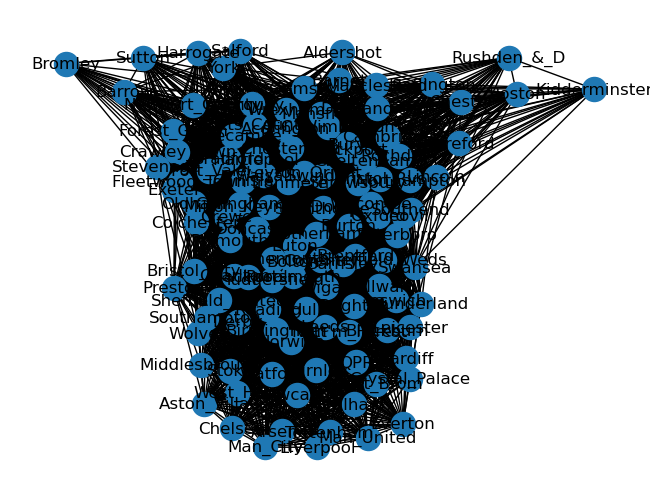

In [35]:
id_list = list(df_train['id']); div_list = list(df_train['Div']); home_list = list(df_train['HomeTeam']); away_list = list(df_train['AwayTeam']); date_list = list(df_train['Date'])
total_list = list(zip(id_list, div_list, date_list))
print(len(total_list))
total_list = list(zip(id_list, div_list, home_list, away_list, date_list))

gg = createGameGraph_uk(total_list)
nx.draw(gg, with_labels=True)
print(len(gg.nodes), len(gg.edges), find_nTotalGames(gg))
assert isConnected(gg)

71 1779 11424


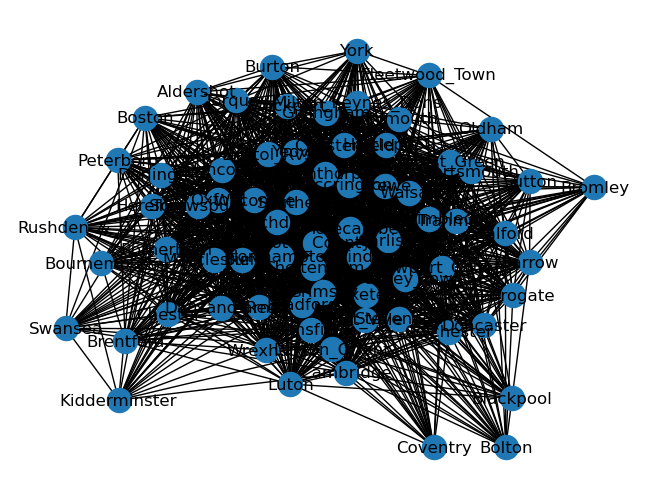

In [57]:

sub_list = [(fixture_id, div, home, away, fixture_date) for (fixture_id, div, home, away, fixture_date) in total_list if div == 'E3']
gg = createGameGraph_uk(sub_list)
nx.draw(gg, with_labels=True)
print(len(gg.nodes), len(gg.edges), find_nTotalGames(gg))
assert isConnected(gg)

In [ ]:
#================= CREATE_MAP_v2 ========================

if TRAIN_MODE:
    targetLength = HISTORY_LEN

    df_sequence = df_train; df_base = df_train
    train_map = YL_assistant.CREATE_MAP_v2(map_folder_path, map_filename_base, targetLength, df_sequence, df_base, year_span=SEQ_YEAR_SPAN, testcount=-1)

    print("\nlen = ", len(train_map))

    seq_types = [sType for (sType, _) in train_map.values()]
    seq_types = list(set([(seq_types.count(sType), sType) for sType in seq_types]))
    seq_types.sort()
    print(seq_types) 

In [ ]:
sub_list = [(fixture_id, div, home, away, fixture_date) for (fixture_id, div, home, away, fixture_date) in total_list if div == 'E3']
gg = createGameGraph_uk(sub_list)
nx.draw(gg, with_labels=True)
print(len(gg.nodes), len(gg.edges), find_nTotalGames(gg))
assert isConnected(gg)